In [3]:
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
import csv
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
import sys
import random
import pandas as pd
from rerank_score_cands_new import load_cands
import numpy as np
from comet import download_model, load_from_checkpoint
import pickle
from sklearn.utils import shuffle
from distill_comet import XLMCometRegressor

csv.field_size_limit(sys.maxsize)
xlm_tok = AutoTokenizer.from_pretrained('xlm-roberta-base')


In [7]:
# nothing is everything
# 1 is with distilled data lattice + beam
# 2 is with just beam data? 
def load_cometqe_data(ind):
    with open('processeddata/commasks'+str(ind)+'.pkl', 'rb') as f:
        masks = pickle.load(f)

    with open('processeddata/cominps'+str(ind)+'.pkl', 'rb') as f:
        xinps = pickle.load(f)

    with open('processeddata/comlabels'+str(ind)+'.pkl', 'rb') as f:
        yinps = pickle.load(f)
    return masks, xinps, yinps

mdata, xdata, ydata = load_cometqe_data(1)

In [8]:
# train test split
cut = int(len(xdata)*.9)
xtrain, ytrain, mtrain = xdata[:cut], ydata[:cut], mdata[:cut]
xtest, ytest, mtest = xdata[cut:], ydata[cut:], mdata[cut:]

In [9]:
del mdata, xdata, ydata
torch.cuda.empty_cache()

In [10]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RegressionDataset(Dataset):
    def __init__(self, sentences, labels, masks):
        assert len(sentences) == len(labels)
        self.sentences = sentences
        self.labels = labels
        self.masks = masks

    def __getitem__(self, i):
        return self.sentences[i], self.labels[i], self.masks[i]

    def __len__(self):
        return len(self.sentences)

def collate_custom(datafull):
    #print(len(datafull[0]))
    data = [torch.tensor(d[0]) for d in datafull]
    masdata=  [d[2] for d in datafull]
    labels = [d[1] for d in datafull]
    max_len = max([x.squeeze().numel() for x in data])
    data = [torch.nn.functional.pad(x, pad=(0, max_len - x.numel()), mode='constant', value=0) for x in data]
    data = torch.stack(data).to(device)
    # TODO just a normal mask for now
    masdata = [torch.ones_like(m) for m in masdata]
    masdata = [torch.nn.functional.pad(x, pad=(0, max_len - x[0].numel(), 0, max_len - x[0].numel()), mode='constant', value=0) for x in masdata]
    masdata = torch.stack(masdata).to(device)
    return data, torch.tensor(labels).to(device), masdata

testloader = DataLoader(RegressionDataset(xtest, ytest, mtest), batch_size=32, shuffle=True, collate_fn=collate_custom)
trainloader = DataLoader(RegressionDataset(xtrain, ytrain, mtrain), batch_size=32, shuffle=True, collate_fn=collate_custom)

In [11]:
tinmax = 100
xtiny, ytiny, mtiny = xtrain[:tinmax], ytrain[:tinmax], mtrain[:tinmax]
tinyloader = DataLoader(RegressionDataset(xtiny, ytiny, mtiny), batch_size=32, shuffle=True, collate_fn=collate_custom)

In [102]:
# hyperparams
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
epochs = 100
total_steps = len(trainloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

loss_function = weighted_mse_loss

In [105]:
from torch.nn.utils.clip_grad import clip_grad_norm_
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    print("Total steps :", total_steps)
    best_loss = 1e10
    for epoch in range(epochs):
        if epoch%1==0:
            print("EPOCH ", epoch)
            print("-----")
            print(best_loss)
        model.train()
        cbest = 1e10
        lostot = 0
        loscnt = 0
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_labels, batch_masks = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            #print(outputs.squeeze().shape)
            #print(batch_labels.squeeze().shape)
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            lostot+=loss
            loscnt+=1
            if step%500==0:
                #print(loss)  
                if loscnt>0:
                    print(lostot/loscnt)
                    cbest = min(float(lostot/loscnt), cbest)
                    best_loss = min(best_loss, cbest)
                    print("cbest, ", cbest)
                    #if cbest==best_loss:
                    #    torch.save(model.state_dict(),"torchsaved/modcomestim"+str(epoch)+".pt")
            #best_loss = min(best_loss, float(loss))
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        cbest = min(float(lostot/loscnt), cbest)
        best_loss = min(best_loss, cbest)
        print("cbest, ", cbest)
        if cbest==best_loss:
            torch.save(model.state_dict(), "torchsaved/maskedminicomestim"+str(epoch)+".pt")
    return model

def evaluate(model, loss_function, tdataloader, device):
    model.eval()
    test_loss, test_r2 = [], []
    preds = []
    ind = 0
    for batch in tdataloader:
        batch_inputs, batch_labels,batch_masks = \
                                 tuple(b.to(device) for b in batch)
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
        preds.extend(list(outputs.squeeze()))
        test_loss.append(loss.item())
        #r2 = r2_score(outputs, batch_labels)
        #test_r2.append(r2.item())
        if ind==10:
            print(batch_labels)
            print(outputs)
        ind+=1
    return test_loss, preds

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def contrast_train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    print("Total steps :", total_steps)
    best_loss = 1e10
    for epoch in range(epochs):
        if epoch%1==0:
            print("EPOCH ", epoch)
            print("-----")
            print(best_loss)
        model.train()
        cbest = 1e10
        lostot = 0
        loscnt = 0
        for step, batch in enumerate(train_dataloader): 
            batch_inputs, batch_labels, batch_masks = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            #print(outputs.squeeze().shape)
            #print(batch_labels.squeeze().shape)
            loss = loss_function(outputs.squeeze(), 
                             batch_labels.squeeze())
            lostot+=loss
            loscnt+=1
            if step%500==0:
                #print(loss)  
                if loscnt>0:
                    print(lostot/loscnt)
                    cbest = min(float(lostot/loscnt), cbest)
                    best_loss = min(best_loss, cbest)
                    print("cbest, ", cbest)
                    if cbest==best_loss:
                        torch.save(model.state_dict(),"torchsaved/modcomestim"+str(epoch)+".pt")
            #best_loss = min(best_loss, float(loss))
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        cbest = min(float(lostot/loscnt), cbest)
        best_loss = min(best_loss, cbest)
        print("cbest, ", cbest)
        if cbest==best_loss:
            torch.save(model.state_dict(), "torchsaved/modcomestim"+str(epoch)+".pt")
    return model

In [ ]:
def RankingLoss(score, summary_score=None, margin=0, gold_margin=0, gold_weight=1, no_gold=False, no_cand=False):
    ones = torch.ones_like(score)
    loss_func = torch.nn.MarginRankingLoss(0.0)
    TotalLoss = loss_func(score, score, ones)
    # candidate loss
    n = score.size(1)
    if not no_cand:
        for i in range(1, n):
            pos_score = score[:, :-i]
            neg_score = score[:, i:]
            pos_score = pos_score.contiguous().view(-1)
            neg_score = neg_score.contiguous().view(-1)
            ones = torch.ones_like(pos_score)
            loss_func = torch.nn.MarginRankingLoss(margin * i)
            loss = loss_func(pos_score, neg_score, ones)
            TotalLoss += loss
    if no_gold:
        return TotalLoss
    # gold summary loss
    pos_score = summary_score.unsqueeze(-1).expand_as(score)
    neg_score = score
    pos_score = pos_score.contiguous().view(-1)
    neg_score = neg_score.contiguous().view(-1)
    ones = torch.ones_like(pos_score)
    loss_func = torch.nn.MarginRankingLoss(gold_margin)
    TotalLoss += gold_weight * loss_func(pos_score, neg_score, ones)
    return TotalLoss


In [9]:
del model 
model = XLMCometRegressor(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/comestim15.pt"))

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [31]:
loss = evaluate(model, torch.nn.MSELoss(), testloader, device)

In [12]:
import math

In [20]:
len(xtrain)

72000

In [32]:
sloss = [math.sqrt(l) for l in loss[0]]

In [121]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
model = train(model, optimizer, scheduler, nn.MSELoss(), 40, 
              tinyloader, device, clip_value=2)

Total steps : 84100
EPOCH  0
-----
10000000000.0
tensor(0.0330, device='cuda:3', grad_fn=<DivBackward0>)
cbest,  0.03302951902151108


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 3; 47.46 GiB total capacity; 16.93 GiB already allocated; 16.44 MiB free; 17.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr=5e-4,
                  eps=1e-8)
model = train(model, optimizer, scheduler, nn.MSELoss(), 2, 
              trainloader, device, clip_value=2)
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
model = train(model, optimizer, scheduler, nn.MSELoss(), 10, 
              trainloader, device, clip_value=2)

In [ ]:
nval = [float(l) for l in loss[1]]

(array([23., 60., 75., 54., 24.,  7.,  2.,  4.,  0.,  1.]),
 array([0.04072549, 0.05284857, 0.06497165, 0.07709473, 0.0892178 ,
        0.10134088, 0.11346396, 0.12558704, 0.13771012, 0.14983319,
        0.16195627]),
 <BarContainer object of 10 artists>)

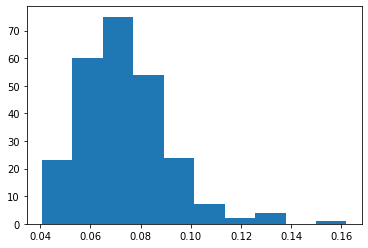

In [35]:
plt.hist(sloss)

In [ ]:
len(ytrain)

In [15]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(alldf['scores'])

In [ ]:
# old data loading stuff

# data comes from WMT 2019 [I think], TODO validate exact year being used
# data generated with gold reference given as hyp
#golddf = pd.read_csv('./processeddata/golddata.csv')
#golddf['inp'] = golddf['fr']
#golddf['hyp'] = golddf['en']
# data generated on candidates from beam search 50 and lattice (lots of bad)
distill_df = pd.read_csv('distill_cometdata_1.csv')
# data generated between random / unrelated sentences 
#rand_df = pd.read_csv('distill_cometdata_rand.csv')[:30000]
# combine
alldf = distill_df#.append(rand_df, ignore_index=True)

In [ ]:
sorted3 = alldf.sort_values(['ref', 'scores']).reset_index().drop(columns=['index'])

In [ ]:
# construct inputs from dataframe
def get_inputs(inpdf):
    xinp = []
    yinp = []
    maskinp = []
    
    for index, row in inpdf.iterrows():
        if index%1000==0:
            print(index)
        #print(row['c1'], row['c2'])
        # will need to make a custom mask (maybe) so that inputs from both languages are encoded separately
        toktmp = xlm_tok(row['inp']).input_ids
        lent = len(toktmp)
        hyptmp = xlm_tok(row['hyp']).input_ids
        toktmp.extend(hyptmp)
        mask = torch.ones(len(toktmp), len(toktmp))
        # should set upper left and bottom right quadrants to 1, mask other stuff
        # TODO make different types of masks. 
        #mask[:lent, :lent] = 1
        #mask[lent:, lent:] = 1
        # make causal encoder-decoder mask
        mask[:lent, lent:] = 0
        mask[lent:, lent:] = torch.tril(mask[lent:, lent:])
        xinp.append(toktmp)
        maskinp.append(mask)
        yinp.append(row['scores'])
    return xinp, yinp, maskinp

In [4]:
xdata, ydata, mdata = get_inputs(alldf)

NameError: name 'get_inputs' is not defined

In [ ]:
for i in range(0, len(xdata)):
    if len(xdata[i])>500:
        del xdata[i]
        del ydata[i]
        del mdata[i]

In [ ]:
# save all as precaution
def save_cometqe_data(md, xd, yd):
    # save data into a pickle file
    with open('processeddata/commasks2.pkl', 'wb') as f:
        pickle.dump(md, f)

    with open('processeddata/cominps2.pkl', 'wb') as f:
        pickle.dump(xd, f)

    with open('processeddata/comlabels2.pkl', 'wb') as f:
        pickle.dump(yd, f)
        
#mdata, xdata, ydata = load_cometqe_data()
        
save_cometqe_data(mdata, xdata, ydata)